# Houses Price Prediction of Karachi

--------

## Import Libraries

In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

--------

## Load Dataset

In [238]:
df = pd.read_csv('D:/DS Bootcamp/Machine Learning/Karachi House Price Prediction/Price-Prediction-of-Karachi-Houses/Karachi Houses Dataset.csv')
df.sample(5)

,property_id,purpose,city,location,beds,baths,area_yard,price,date_added
6835,Property_6836,Sale,Karachi,"North Nazimabad - Block J, North Nazimabad",3,3,200 Sq. Yd.,3.6 Crore,NaN
11874,Property_11875,Sale,Karachi,"Bahria Town - Precinct 8, Bahria Town Karachi",3,4,250 Sq. Yd.,2.7 Crore,NaN
782,Property_783,Sale,Karachi,"Kathiawar Society, Gulshan-e-Iqbal Town",3,3,240 Sq. Yd.,5.6 Crore,2025-04-21
11282,Property_11283,Sale,Karachi,"DHA Phase 8, DHA Defence",6,6,666 Sq. Yd.,2.1 Crore,NaN
9078,Property_9079,Sale,Karachi,"PECHS, Jamshed Town",5,5,250 Sq. Yd.,12.25 Crore,NaN


In [239]:
df[df['property_id']=='Property_11610']

,property_id,purpose,city,location,beds,baths,area_yard,price,date_added
11609,Property_11610,Sale,Karachi,"Clifton - Block 5, Clifton",10,6,"2,000 Sq. Yd.",16 Crore,2025-02-25


----------

## Data Preprocessing

### Data Anomilies 

Correct the data typos and anomilies on the dataset

From location extract only the house location area socities
like Scheme 33, DHA etc

In [240]:
import re
locations = ['DHA', 'Malir', 'Scheme 33', 'Naya Nazimabad', 'Gadap Town', 'North Nazimabad', 
             'Gulistan-e-Jauhar', 'Federal B Area', 'PECHS', 'Gulshan-e-Iqbal', 'Gulshan-e-Maymar', 
             'North Karachi', 'Shadman Town', 'Clifton', 'Askari 5', 'Surjani Town', 'Bahria', 'Scheme 1', 
             'Saima Villas', 'Saadi Garden', 'Karsaz', 'Saadi Town', 'Bufferzone', 'NHS Mauripur', 'KN Gohar Green', 
             'Gulshan-e-Roomi','Landhi','Falcon Complex', 'Saima Luxury', 'Jamshed Town','Amir Khusro', 'Ilyas Goth', 
             'Airport Road', 'Zamzama', 'Faisal Cantonment','Sindhi Muslim Society', 'Bath Island', 'Shahra-e-Faisal', 
             'Defence View', 'Shaheed Millat Road', 'Gulshan-e-Kaneez Fatima', 'Chapal Uptown']

def extract_location(location):
    for loc in locations:
        if loc in location:
            return loc
    return None

In [241]:
df['society'] = df['location'].apply(extract_location)

During scrapping the data scraped had some errors, like in baths and beds columns some values of area_yard were included

Correct the baths column 

In [242]:
area_condition = df['baths'].str.contains('Sq. Yd.', na=False)

df.loc[area_condition, 'area_yard'] = df.loc[area_condition, 'baths']

df.loc[area_condition, 'baths'] = None

Correct the beds column

In [243]:
area_condition = df['beds'].str.contains('Sq. Yd.', na=False)

df.loc[area_condition, 'area_yard'] = df.loc[area_condition, 'beds']

df.loc[area_condition, 'beds'] = None

Convert the area_yard into sq_feet

In [244]:
df['area_yard_clean'] = df['area_yard'].str.replace(',', '', regex=False)

df['area_num'] = df['area_yard_clean'].str.extract('(\d+)', expand=False).astype(float)

df['area_in_sqft'] = df['area_num'] * 9

Convert the price to numeric values

In [245]:
def convert_price(price):
    if isinstance(price, float):
        return price

    if 'Crore' in price:
        value = float(re.sub(r'[^\d.]', '', price))  
        return value * 10000000  
    elif 'Lakh' in price:
        value = float(re.sub(r'[^\d.]', '', price))  
        return value * 100000  
    
    return float(re.sub(r'[^\d.]', '', price))

In [246]:
df['numeric_price'] = df['price'].apply(convert_price)

Change the numeric data column type into int

In [247]:
num = ['beds', 'baths']

for i in num:
    df[i]=pd.to_numeric(df[i], errors='coerce')

In [248]:
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

Remove unnecessary columns

In [249]:
df.drop(columns=['purpose','city','location','area_yard','area_num','price', 'area_yard_clean'],inplace=True)

Rename the numeric price column to price

In [250]:
df.rename(columns={'numeric_price':'price'}, inplace=True)

-------

### Handle missing values

In [251]:
print('Missing values in the dataset:')
(df.isnull().sum() / len(df) * 100).sort_values(ascending=False)

Missing values in the dataset:


date_added      43.484407
baths            7.800416
beds             6.644491
price            4.000000
society          3.135135
property_id      0.000000
area_in_sqft     0.000000
dtype: float64

firstly we fill the missing values that are less then 10%

**Steps**
- Check is data is MCAR or not
- Check the distribution of data before and after imputation

We have a beautifull library called missingo, which can help us to see the values are MCAR or not.

<Axes: >

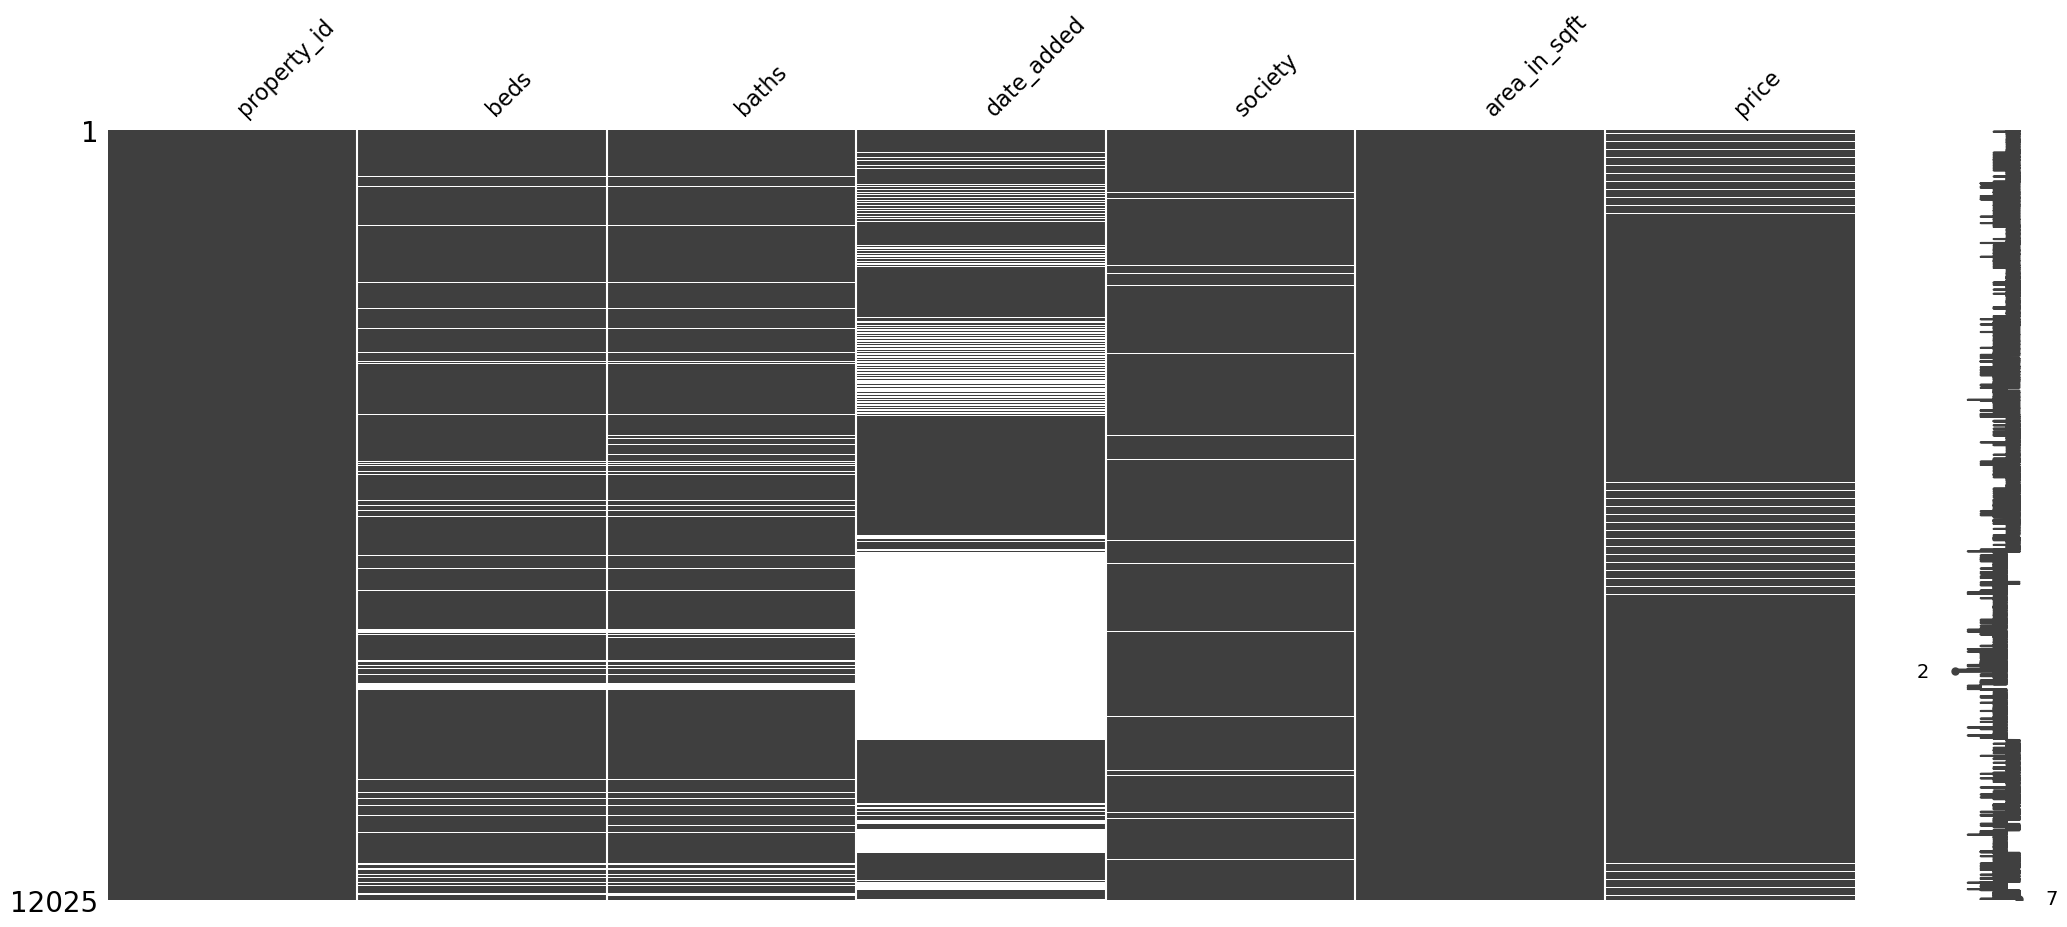

In [252]:
msno.matrix(df)

- First, we drop the rows with missing values in the target column. Filling these missing values could introduce bias into the model.
- In the society column, missing values cannot be filled reliably because we lack sufficient information about which houses belong to which society.

In [253]:
df.dropna(subset=['price', 'society'], inplace=True)

exluded date_added, remain features missing values are MCAR.
Now check the Distribution of these columns

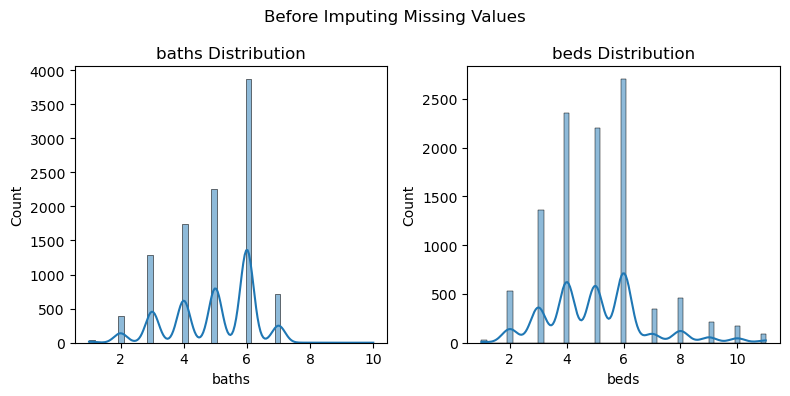

In [254]:
num_missing = ['baths','beds']

plt.figure(figsize=(8,4))
for i, col in enumerate(num_missing):
    plt.subplot(1,2,i+1)
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'{col} Distribution')
    plt.suptitle('Before Imputing Missing Values')
plt.tight_layout()
plt.show()


- As our baths feature values from 1 - 10, 
- Beds feature values from 1-11.

- In baths we use mode as the 6 apears more in the data so it can't effect on distribution 

In [255]:
df['baths'].fillna(df['baths'].mode()[0], inplace=True)

Approximately 6.6% of values are missing in the beds column. To preserve the original distribution, we fill missing values evenly with 4, 5, or 6

In [256]:
fill_values = [4, 5, 6]
missing_beds = df[df['beds'].isna()].index
df.loc[missing_beds, 'beds'] = np.random.choice(fill_values, size=len(missing_beds), replace=True)

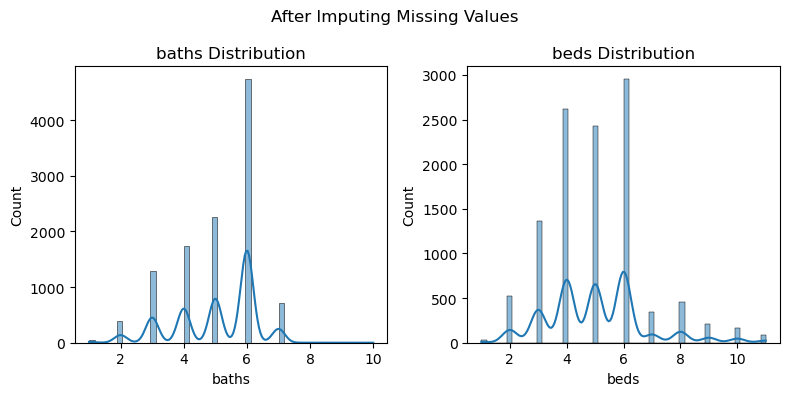

In [257]:
plt.figure(figsize=(8,4))
for i, col in enumerate(num_missing):
    plt.subplot(1,2,i+1)
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'{col} Distribution')
    plt.suptitle('After Imputing Missing Values')
plt.tight_layout()
plt.show()

For EDA purposes, missing dates were backward filled to retain data quantity. Caution is advised while interpreting time-based insights

In [258]:
df['date_added'] = df['date_added'].bfill()

--------

### Data Summary

In [259]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 11177 entries, 0 to 12024
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   property_id   11177 non-null  object        
 1   beds          11177 non-null  float64       
 2   baths         11177 non-null  float64       
 3   date_added    11166 non-null  datetime64[ns]
 4   society       11177 non-null  object        
 5   area_in_sqft  11177 non-null  float64       
 6   price         11177 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 956.6+ KB


,beds,baths,date_added,area_in_sqft,price
count,11177.000000,11177.000000,11166,11177.000000,1.117700e+04
mean,5.014584,5.044108,2025-04-08 12:49:46.781299968,3142.147446,8.279051e+07
min,1.000000,1.000000,2023-11-03 00:00:00,45.000000,1.000000e+00
25%,4.000000,4.000000,2025-03-27 00:00:00,1125.000000,2.580000e+07
50%,5.000000,5.000000,2025-04-22 00:00:00,2250.000000,5.600000e+07
75%,6.000000,6.000000,2025-04-25 00:00:00,4500.000000,1.060000e+08
max,11.000000,10.000000,2025-04-26 00:00:00,171000.000000,8.500000e+08
std,1.702944,1.293784,NaN,3118.576117,8.638026e+07


**Beds**
- The number of beds in the houses from 1 to 11.

**Baths**
- The number of bathrooms in the houses from 1 to 10.

**Date_added**
- The data is from 2024 - 2025

**Area_in_sqft**
- 

-----------

There are no duplicated Rows in the dataset

In [260]:
df.duplicated().sum()

0

----------

### Handle Outliers

In [261]:
df[df['area_in_sqft'] > 18000]

,property_id,beds,baths,date_added,society,area_in_sqft,price
421,Property_422,11.0,6.0,2025-04-26,DHA,45000.0,4.500000e+07
1030,Property_1031,10.0,6.0,2025-04-26,DHA,90000.0,3.150000e+07
1509,Property_1510,11.0,7.0,2025-04-26,Scheme 33,19827.0,1.450000e+08
2440,Property_2441,11.0,7.0,2025-04-24,DHA,36000.0,3.500000e+07
2830,Property_2831,5.0,5.0,2025-04-21,Naya Nazimabad,27000.0,3.200000e+07
3209,Property_3210,11.0,7.0,2025-04-26,DHA,27000.0,1.150000e+08
3778,Property_3779,6.0,6.0,2025-04-23,DHA,36000.0,1.050000e+00
4440,Property_4441,5.0,6.0,2025-04-24,DHA,19800.0,1.800000e+08
4441,Property_4442,5.0,5.0,2025-04-24,DHA,19800.0,4.500000e+08
5972,Property_5973,10.0,6.0,2025-04-22,PECHS,24300.0,6.500000e+07
